In [0]:
# pip install pyspark

# Start a pyspark session

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType,IntegerType, ArrayType
from pyspark.sql.functions import col, when
import pyspark.sql.functions as F

# Data Reading

In [0]:
# spark.sql("CREATE DATABASE dsci5350_db")
# spark.sql("USE dsci5350_db")
user = spark.read.csv('/FileStore/tables/JD_user_data-2.csv', header=True)
order=spark.read.csv('/FileStore/tables/JD_order_data-2.csv', header=True)
user.write.saveAsTable("User1")
order.write.saveAsTable("Order1")


In [0]:
user=spark.sql("SELECT * FROM User1")
order=spark.sql("SELECT * FROM Order1")

In [0]:
spark.sql("SELECT * FROM User1 WHERE user_ID = '777848e557'").show()
spark.sql("SELECT COUNT(*) AS user_count FROM User1").show()

+----------+----------+-----------------+----+------+---+--------------+---------+----------+--------------+
|   user_ID|user_level|first_order_month|plus|gender|age|marital_status|education|city_level|purchase_power|
+----------+----------+-----------------+----+------+---+--------------+---------+----------+--------------+
|777848e557|         4|          2014-11|   0|     U|  U|             U|       -1|        -1|            -1|
+----------+----------+-----------------+----+------+---+--------------+---------+----------+--------------+

+----------+
|user_count|
+----------+
|    457298|
+----------+



# Data Preprocessing

# Fixing Data types

In [0]:
user.printSchema()
order.printSchema()

root
 |-- user_ID: string (nullable = true)
 |-- user_level: string (nullable = true)
 |-- first_order_month: string (nullable = true)
 |-- plus: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- education: string (nullable = true)
 |-- city_level: string (nullable = true)
 |-- purchase_power: string (nullable = true)

root
 |-- order_ID: string (nullable = true)
 |-- user_ID: string (nullable = true)
 |-- sku_ID: string (nullable = true)
 |-- order_date: string (nullable = true)
 |-- order_time: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- type: string (nullable = true)
 |-- promise: string (nullable = true)
 |-- original_unit_price: string (nullable = true)
 |-- final_unit_price: string (nullable = true)
 |-- direct_discount_per_unit: string (nullable = true)
 |-- quantity_discount_per_unit: string (nullable = true)
 |-- bundle_discount_per_unit: string (nullabl

Promise variable represents Expected delivery time (in days) which has 1 to 8 numbers but it has '-' in few columns so dataframe is reading as string. Converting '-' records with new value 9 since there are more 50% missing values and change the datatype to string.

In [0]:
from pyspark.sql.functions import col, when

# Define the replacement number for "-"
replacement_number = 9

# Replace "-" with `replacement_number` in the "promise" column
order = order.withColumn("promise", when(col("promise") == "-", replacement_number).otherwise(col("promise")))

#Change datatype
order = order.withColumn("promise", col("promise").cast("int"))

# Handling null values or missing values

In [0]:
from pyspark.sql.functions import col, sum as sum_

# Check for null values in the 'user' DataFrame
user_null_counts = user.select([sum_(col(column).isNull().cast("int")).alias(column) for column in user.columns])
user_null_counts.show()

# Check for null values in the 'order' DataFrame
order_null_counts = order.select([sum_(col(column).isNull().cast("int")).alias(column) for column in order.columns])
order_null_counts.show()

+-------+----------+-----------------+----+------+---+--------------+---------+----------+--------------+
|user_ID|user_level|first_order_month|plus|gender|age|marital_status|education|city_level|purchase_power|
+-------+----------+-----------------+----+------+---+--------------+---------+----------+--------------+
|      0|         0|                0|   0|     0|  0|             0|        0|         0|             0|
+-------+----------+-----------------+----+------+---+--------------+---------+----------+--------------+

+--------+-------+------+----------+----------+--------+----+-------+-------------------+----------------+------------------------+--------------------------+------------------------+------------------------+---------+------+------+
|order_ID|user_ID|sku_ID|order_date|order_time|quantity|type|promise|original_unit_price|final_unit_price|direct_discount_per_unit|quantity_discount_per_unit|bundle_discount_per_unit|coupon_discount_per_unit|gift_item|dc_ori|dc_des|
+--

Although the columns such as gender, age, marital_status, education, city_level, and purchase_power don't contain null values, they have unidentified values that essentially act as missing data. 

The various age groups in Age column are “<=15,” “16-25,” “26-35,” “36-45,” “46-55,” “>=56,” and “U”. The unknowns in the Age column represented by “U” were replaced by random imputation. The string values representing the different age groups are converted to numeric values according to their order. 0 is assigned to the youngest age group and 5 to the oldest user age group. 
 
To address unknown values and ensure the completeness of the dataset for analysis, the unknown values in the user features(Marital Status, Age, Gender) are imputed by random sampling technique. The probability of selecting each category was determined by its relative frequency in the dataset.

In [0]:
from pyspark.sql.functions import when, lit
 
# Replace "U" with a random gender "M" or "S"
user = user.withColumn("marital_status",
                   when(col("marital_status") == "U",
                        when(F.rand() < 0.5, "M").otherwise("S")).otherwise(col("marital_status")))

# Replace "U" with a random gender "M" or "F"
user = user.withColumn("gender",
                   when(col("gender") == "U",
                        when(F.rand() < 0.5, "M").otherwise("F")).otherwise(col("gender")))

# Replace "-1" with a random city_level
user = user.withColumn("city_level",
                   when(col("city_level") == -1,
                        when(F.rand() < 0.25, 1)
                        .when(F.rand() < 0.5, 2)
                        .when(F.rand() < 0.75, 3)
                        .otherwise(4)).otherwise(col("city_level")))

# Replace "-1" with a random purchase_power
user = user.withColumn("purchase_power",
                   when(col("purchase_power") == -1,
                        when(F.rand() < 0.25, 1)
                        .when(F.rand() < 0.5, 2)
                        .when(F.rand() < 0.75, 3)
                        .otherwise(4)).otherwise(col("purchase_power")))
 

# Replace "-1" with a random education level
user = user.withColumn("education",
                   when(col("education") == -1,
                        when(F.rand() < 0.25, 1)
                        .when(F.rand() < 0.5, 2)
                        .when(F.rand() < 0.75, 3)
                        .otherwise(4)).otherwise(col("education")))

# Replace "U" with a random age range
user = user.withColumn("age",
                   when(col("age") == "U",
                        when(F.rand() < 0.25, "16-25")
                        .when(F.rand() < 0.5, "26-35")
                        .when(F.rand() < 0.75, "36-45")
                        .otherwise(">=56")).otherwise(col("age")))
 
user.show(10)

+----------+----------+-----------------+----+------+-----+--------------+---------+----------+--------------+
|   user_ID|user_level|first_order_month|plus|gender|  age|marital_status|education|city_level|purchase_power|
+----------+----------+-----------------+----+------+-----+--------------+---------+----------+--------------+
|777848e557|         4|          2014-11|   0|     F|26-35|             M|        1|         2|             2|
|777923a4c2|         4|          2013-11|   1|     F|26-35|             M|        3|         2|             2|
|7779465090|         2|          2016-08|   0|     M| >=56|             M|        2|         3|             2|
|77798803de|         2|          2016-09|   0|     F|26-35|             S|        3|         2|             2|
|77799cfb7e|         4|          2010-12|   1|     F|36-45|             M|        4|         1|             2|
|7779bc8ea3|         2|          2015-03|   0|     M| >=56|             S|        3|         1|             2|
|

# Check for Outliers

In [0]:
from pyspark.sql.functions import col, lit
from pyspark.sql.functions import col, desc

# Function to calculate and show outliers based on occurrence counts for each numerical column
def check_numerical_outliers_by_occurrence(df):
    for column in df.dtypes:
        if column[1] in ('int', 'float', 'double'):
            # Count the occurrences of each numerical value
            frequency = df.groupBy(column[0]).count().orderBy(desc('count'))

            # Show the categories with their counts
            print(f"Occurrence distribution for {column[0]}:")
            #frequency.show()

            # Define a threshold for rare occurrences, e.g., less than 1% of the total rows
            total_rows = df.count()
            threshold = 0.01 * total_rows

            # Identify the rare occurrences
            rare_occurrences = frequency.filter(col('count') < threshold)
            print(f"Rare occurrences in {column[0]} (less than 1% of total rows):")
            rare_occurrences.show()

print("Outliers in numerical variables of 'user' DataFrame based on occurrence:")
check_numerical_outliers_by_occurrence(user)

# Check for outliers in 'order' DataFrame
#print("\nOutliers in 'order' DataFrame:")
#check_outliers(order)


# Function to analyze categorical variables for outliers
def check_categorical_outliers(df, columns):
    for column in columns:
        if df.schema[column].dataType.simpleString() == 'string':
            # Count the occurrences of each category
            frequency = df.groupBy(column).count().orderBy(desc('count'))

            # Show the categories with their counts
            print(f"Frequency distribution for {column}:")
            #frequency.show()

            # Alternatively, you might want to look for categories with very low counts as potential outliers
            # Here we show categories that have a count less than a specific threshold, e.g., 1% of the total rows
            total_rows = df.count()
            threshold = 0.01 * total_rows
            rare_categories = frequency.filter(col('count') < threshold)
            print(f"Rare categories in {column} (less than 1% of total rows):")
            rare_categories.show()
        else:
            print(f"Column '{column}' is not categorical and will be skipped.")

categorical_columns_user = ['gender', 'marital_status','age']
print("Outliers in categorical variables of 'user' DataFrame:")
check_categorical_outliers(user, categorical_columns_user)


Outliers in numerical variables of 'user' DataFrame based on occurrence:
Outliers in categorical variables of 'user' DataFrame:
Frequency distribution for gender:
Rare categories in gender (less than 1% of total rows):
+------+-----+
|gender|count|
+------+-----+
+------+-----+

Frequency distribution for marital_status:
Rare categories in marital_status (less than 1% of total rows):
+--------------+-----+
|marital_status|count|
+--------------+-----+
+--------------+-----+

Frequency distribution for age:
Rare categories in age (less than 1% of total rows):
+----+-----+
| age|count|
+----+-----+
|<=15|   24|
+----+-----+



In [0]:
from pyspark.sql.functions import when,rand
 
# Replace "-1" and "0" with values 1, 2, 3, and 4

user = user.withColumn("random_value", rand())

user = user.withColumn("user_level",
                       when((col("user_level") == -1) | (col("user_level") == 0),
                            when(col("random_value") < 0.25, 1)
                            .when(col("random_value") < 0.5, 2)
                            .when(col("random_value") < 0.75, 3)
                            .otherwise(4))
                       .otherwise(col("user_level"))).drop("random_value")


This attribute represents 0 for regular customers, 1 for plus members. 
If the attribute represents 0 for regular customers and 1 for plus members, and there are fewer plus members compared to regular customers, it doesn't necessarily mean that the plus members should be considered outliers. Outliers are typically data points that significantly deviate from the rest of the dataset, and they may be due to measurement errors, experimental variability, or genuine unusual observations.

For users who are enterprise users (e.g., small shops in rural areas or small businesses), considering them as user_level 10 is being treated as outliers, so we are not removing them.

Drop outilers in purchase_power and age 

In [0]:
user = user.filter(user['age'] != '<=15')
user = user.filter(user['purchase_power'] != 5)

In [0]:
print("Outliers in numerical variables of 'user' DataFrame based on occurrence:")
check_numerical_outliers_by_occurrence(user)

categorical_columns_user = ['gender', 'marital_status','age']
print("Outliers in categorical variables of 'user' DataFrame:")
check_categorical_outliers(user, categorical_columns_user)

Outliers in numerical variables of 'user' DataFrame based on occurrence:
Outliers in categorical variables of 'user' DataFrame:
Frequency distribution for gender:
Rare categories in gender (less than 1% of total rows):
+------+-----+
|gender|count|
+------+-----+
+------+-----+

Frequency distribution for marital_status:
Rare categories in marital_status (less than 1% of total rows):
+--------------+-----+
|marital_status|count|
+--------------+-----+
+--------------+-----+

Frequency distribution for age:
Rare categories in age (less than 1% of total rows):
+---+-----+
|age|count|
+---+-----+
+---+-----+



# Explanatory Data Analysis

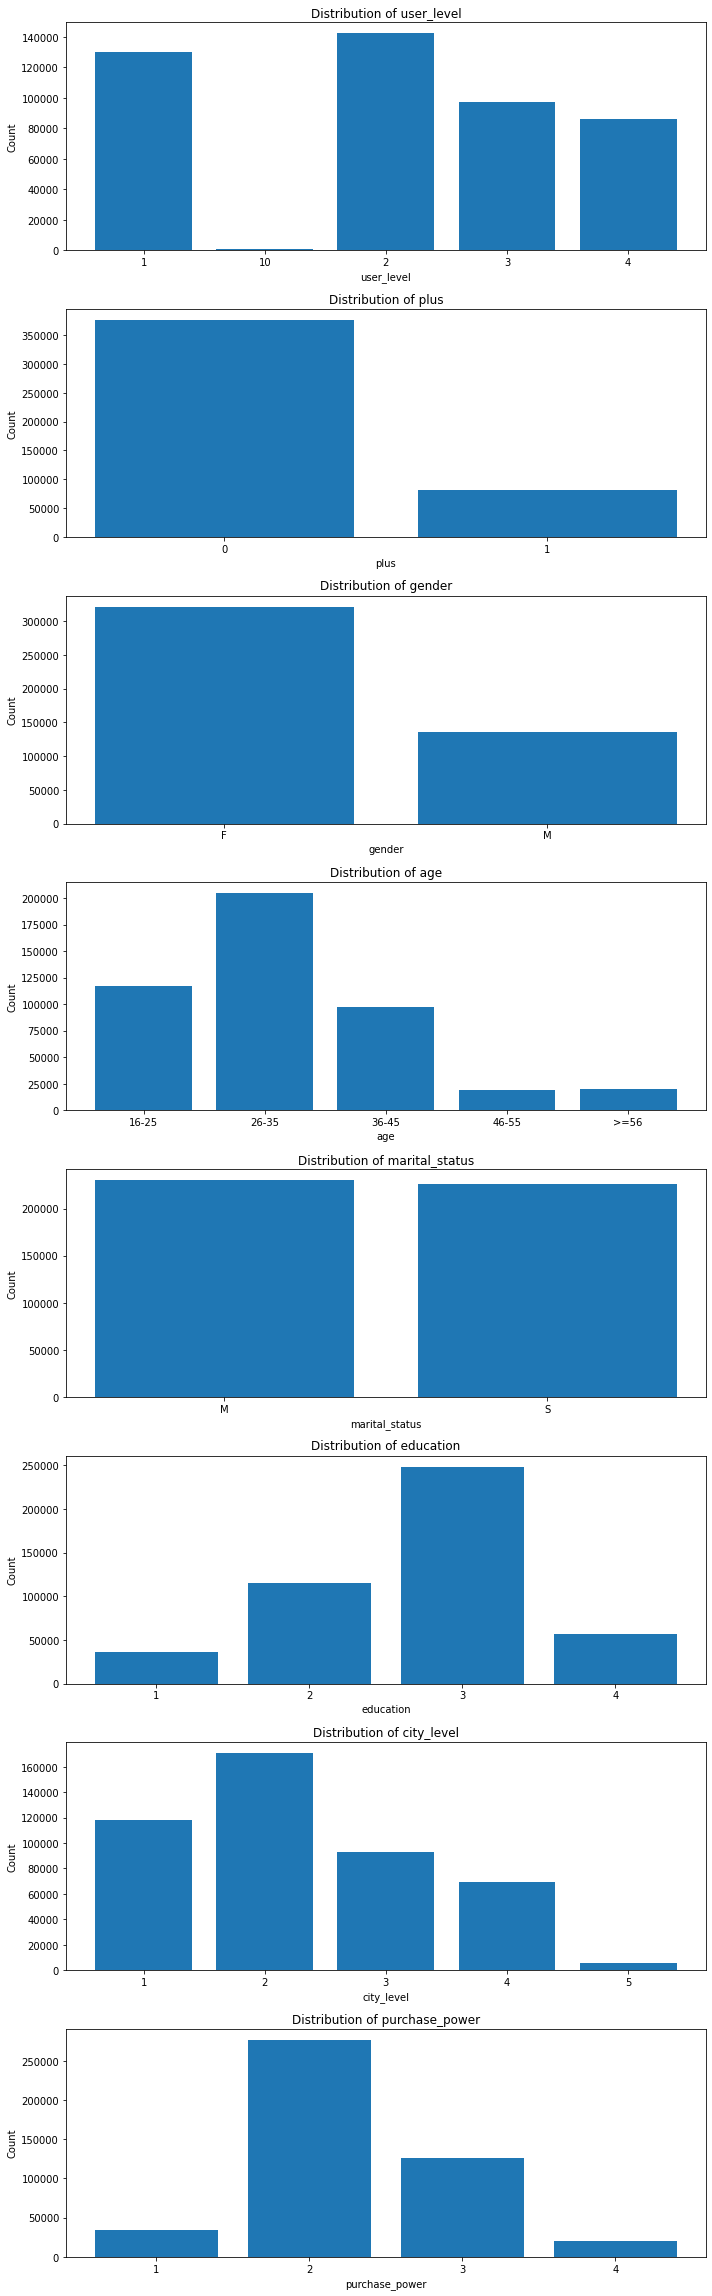

In [0]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# List of categorical columns
categorical_columns = ['user_level', 'plus', 'gender', 'age', 'marital_status', 'education', 'city_level', 'purchase_power']

# Initialize the matplotlib figure and axes
fig, axes = plt.subplots(nrows=len(categorical_columns), ncols=1, figsize=(10, 4 * len(categorical_columns)))

for i, column in enumerate(categorical_columns):
    # Get the distribution of the current categorical column
    distribution = user.groupBy(column).count().orderBy(col(column).asc()).collect()

    # Extract the categories and their counts
    categories = [row[column] for row in distribution]
    counts = [row['count'] for row in distribution]

    # Plot the distribution
    ax = axes[i]
    ax.bar(categories, counts)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

    # Ensure the x-axis ticks are integers
    ax.set_xticks(categories)  # Set the ticks to be the categories
    ax.set_xticklabels(categories)  # Set the tick labels to be the categories

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

# Which age group is more likely to make purchases based on their education level.

In [0]:
from pyspark.sql.functions import count

# Pivot table in PySpark
pivot_table = user.groupBy("age").pivot("education").agg(count("user_ID")).fillna(0)

# Show the pivot table
pivot_table.show()

# Pivot table in PySpark
target = user.groupBy("gender").pivot("age").agg(count("user_ID")).fillna(0)

# Show the pivot table
target.show()


+-----+-----+-----+------+-----+
|  age|    1|    2|     3|    4|
+-----+-----+-----+------+-----+
| >=56| 2682| 5809|  8764| 2540|
|26-35|12204|43909|121221|27218|
|16-25|11449|39029| 61147| 5595|
|46-55| 1563| 4716|  9458| 2932|
|36-45| 7777|22248| 48045|18819|
+-----+-----+-----+------+-----+

+------+-----+------+-----+-----+-----+
|gender|16-25| 26-35|36-45|46-55| >=56|
+------+-----+------+-----+-----+-----+
|     F|84421|143988|66039|13722|13196|
|     M|32799| 60564|30850| 4947| 6599|
+------+-----+------+-----+-----+-----+



# New Users trend

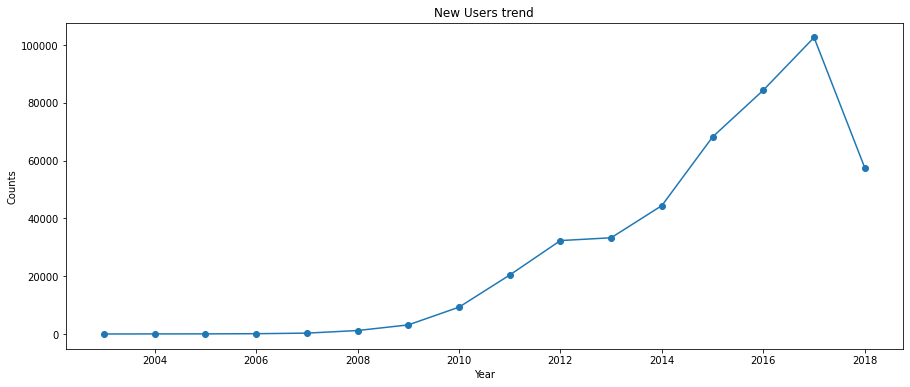

In [0]:
from pyspark.sql.functions import substring, col
import matplotlib.pyplot as plt
 
# Extract year from "first_order" column
user = user.withColumn("year", col("first_order_month").substr(1, 4))
 
# Convert year to numeric format
user = user.withColumn("year", user["year"].cast("int"))
 
# Sort the DataFrame by year
user = user.orderBy("year")
 
# Calculate counts of users for each year
year_counts = user.groupBy("year").count().orderBy("year")
 
# Convert PySpark DataFrame to Pandas for plotting
year_counts_pandas = year_counts.toPandas()
 
# Plot the trend
plt.figure(figsize=(15, 6))
plt.plot(year_counts_pandas["year"], year_counts_pandas["count"], marker="o")
plt.title("New Users trend")
plt.xlabel("Year")
plt.ylabel("Counts")
plt.show()

New users to JD.com are has an exponential increase trend (2018 has the data for first 3 months. So there is a decline trend.)

# Top 10 Customers by Amount Purchased in JD.com and the quantity Pruchased

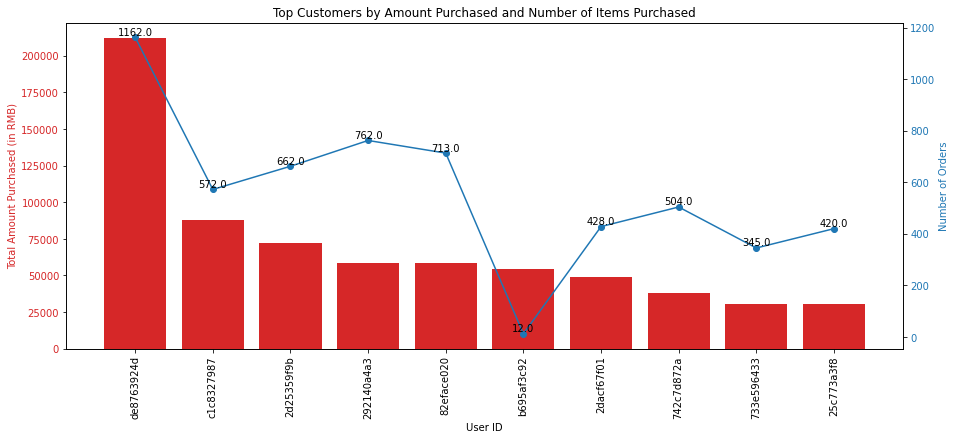

In [0]:
from pyspark.sql.functions import col, sum as sum_

# Calculate the amount for each order
order = order.withColumn('amount', col('quantity') * col('final_unit_price'))

# Get top customers by total amount purchased
top_customers_by_amount = order.groupBy('user_ID') \
                               .agg(sum_('amount').alias('total_amount')) \
                               .orderBy(col('total_amount').desc()) \
                               .limit(10)

# Get number of items they purchased individually
top_customers_by_orders = order.groupBy('user_ID') \
                               .agg(sum_('quantity').alias('total_quantity')) \
                               .join(top_customers_by_amount, 'user_ID') \
                               .select('user_ID', 'total_quantity') \
                               .orderBy(col('total_amount').desc())

# Collect data to the driver for plotting
top_customers_by_amount = top_customers_by_amount.toPandas()
top_customers_by_orders = top_customers_by_orders.toPandas()

# Plotting the dual-axis chart using Matplotlib
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(15, 6))

# Plotting top customers by amount as bars on first y-axis
color = 'tab:red'
ax1.set_xlabel('User ID')
ax1.set_ylabel('Total Amount Purchased (in RMB)', color=color)
ax1.bar(top_customers_by_amount['user_ID'], top_customers_by_amount['total_amount'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(len(top_customers_by_amount['user_ID'])))
ax1.set_xticklabels(top_customers_by_amount['user_ID'], rotation=90)

# Creating the second y-axis and plotting top customers by orders as a line
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Number of Items purchased by that Customer', color=color)
ax2.plot(range(len(top_customers_by_orders['user_ID'])), top_customers_by_orders['total_quantity'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Adding annotations to the line plot
for i, v in enumerate(top_customers_by_orders['total_quantity']):
    ax2.text(i, v + 1, str(v), ha='center', va='bottom')

# Adding title and labels
plt.title('Top Customers by Amount Purchased and Number of Items Purchased')
ax1.set_xlabel('User ID')
ax2.set_ylabel('Number of Orders')

plt.show()

The above graph represents top 10 customers who have made substantial contribution to JD.com's revenue. For example customer with user_ID 'de8763924d' stands out by purchasing RMB 21,2088.24(0.45% of total revenue generated in March) consisting of 1162 products in the month of March. This customer is not a JD plus member and we can recommend this user as a potential JD plus member to retain the valuable customer.

# Top 10 Products customer ordered more frequently 

+----------+-----------------+
|    sku_ID|count_occurrences|
+----------+-----------------+
|068f4481b3|            23655|
|3c79df1d80|            14463|
|a9109972d1|            12176|
|623d0a582a|            10175|
|8dc4a01dec|             9891|
|fbce41fd82|             8386|
|904fbf8b97|             7913|
|ca7647a231|             6456|
|38d636d2a6|             6446|
|7e4cb4952a|             5567|
+----------+-----------------+

<Figure size 1080x432 with 0 Axes>

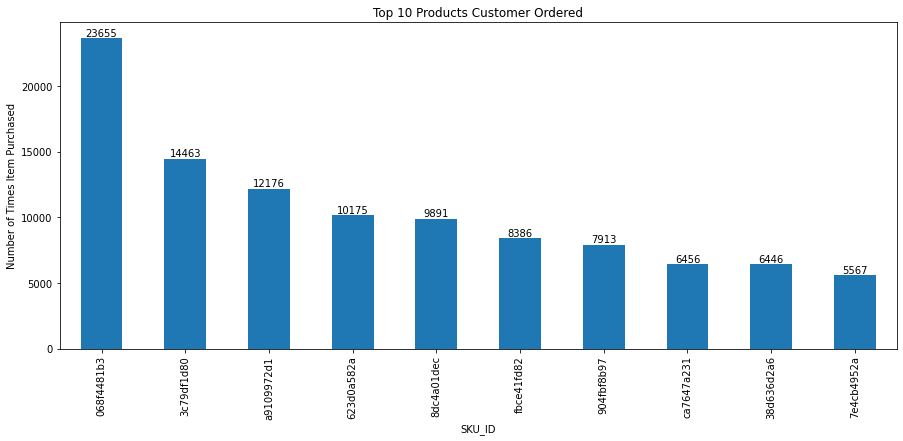

In [0]:
from pyspark.sql.functions import col, desc

# Group by sku_ID, count the occurrences, and sort in descending order
product_counts = order.groupBy("sku_ID").count().withColumnRenamed("count", "count_occurrences")
top_products = product_counts.orderBy(desc("count_occurrences")).limit(10)

# Show the top products
top_products.show()

# Collecting the data to a Pandas DataFrame for plotting
top_products_pandas = top_products.toPandas()

import matplotlib.pyplot as plt

# Plotting the data using Matplotlib with specified figure size
plt.figure(figsize=(15, 6))
ax = top_products_pandas.plot(kind='bar', x='sku_ID', y='count_occurrences', legend=None, figsize=(15, 6))
plt.title('Top 10 Products Customer Ordered')
plt.xlabel('SKU_ID')
plt.xticks(rotation='vertical')
plt.ylabel('Number of Times Item Purchased')

# Annotate the bar chart with the height of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

# Add a comment for above graph

# Predictng the customer purchases

In [0]:
from pyspark.sql.types import IntegerType
# Replace age categories with numerical values
user = user.withColumn("age",
                       when(user["age"] == ">=56", 5)
                       .when(user["age"] == "46-55", 4)
                       .when(user["age"] == "36-45", 3)
                       .when(user["age"] == "26-35", 2)
                       .when(user["age"] == "16-25", 1)
                       .otherwise(user["age"]).cast(IntegerType()))

# Replace gender values with integers
user = user.withColumn("gender",
                       when(user["gender"] == "F", 0)
                       .when(user["gender"] == "M", 1)
                       .otherwise(user["gender"]).cast(IntegerType()))
 
# Replace gender values with integers
user = user.withColumn("marital_status",
                       when(user["marital_status"] == "S", 0)
                       .when(user["marital_status"] == "M", 1)
                       .otherwise(user["marital_status"]).cast(IntegerType()))

In [0]:
order_user = spark.sql("SELECT * FROM User1 LEFT JOIN Order1 ON User1.user_ID = Order1.user_ID")

In [0]:
# Perform the merge operation equivalent to pandas 'merge'
order_user = spark.sql("SELECT * FROM User1 LEFT JOIN Order1 ON User1.user_ID = Order1.user_ID")
# Create a new column 'purchased' which is 1 if 'order_ID' is not null, otherwise 0
order_user = order_user.withColumn('purchased', when(col('order_ID').isNull(), 0).otherwise(1))

# Show the shape of the DataFrame in terms of number of rows and columns
print(f"Number of rows: {order_user.count()}, Number of columns: {len(order_user.columns)}")

# Show the columns of the DataFrame
print(f"Columns: {order_user.columns}")

Number of rows: 552390, Number of columns: 28
Columns: ['user_ID', 'user_level', 'first_order_month', 'plus', 'gender', 'age', 'marital_status', 'education', 'city_level', 'purchase_power', 'order_ID', 'user_ID', 'sku_ID', 'order_date', 'order_time', 'quantity', 'type', 'promise', 'original_unit_price', 'final_unit_price', 'direct_discount_per_unit', 'quantity_discount_per_unit', 'bundle_discount_per_unit', 'coupon_discount_per_unit', 'gift_item', 'dc_ori', 'dc_des', 'purchased']


In [0]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml import Pipeline

# List of feature columns and target column
features = ['user_level', 'plus', 'gender', 'age', 'marital_status', 'education', 'city_level', 'purchase_power']
target = 'purchased'

# Create a DataFrame only containing the necessary columns
data = order_user.select(features + [target])

# Checking for missing values in each column
null_counts = data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns])

# Show the result
null_counts.show()

+----------+----+------+---+--------------+---------+----------+--------------+---------+
|user_level|plus|gender|age|marital_status|education|city_level|purchase_power|purchased|
+----------+----+------+---+--------------+---------+----------+--------------+---------+
|         0|   0|     0|  0|             0|        0|         0|             0|        0|
+----------+----+------+---+--------------+---------+----------+--------------+---------+



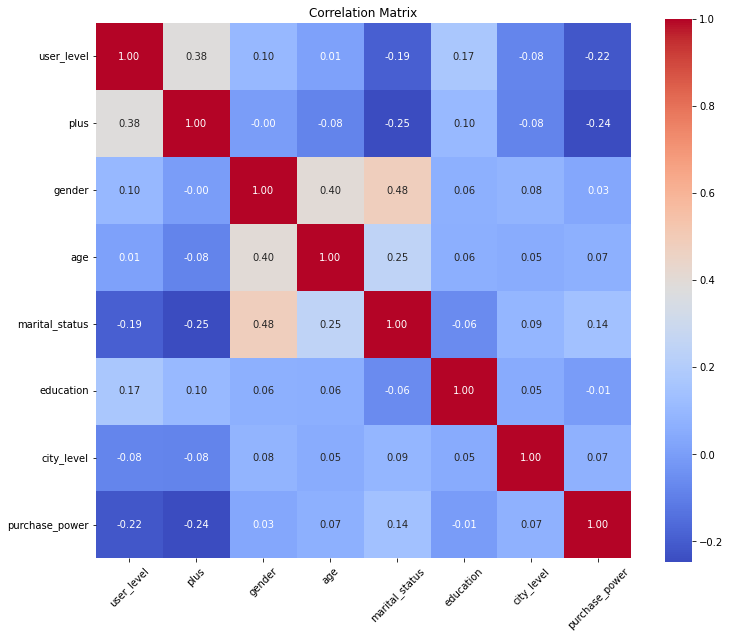

In [0]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data =order_user ['user_level', 'plus', 'gender', 'age', 'marital_status', 'education', 'city_level', 'purchase_power','purchased']

# All features considered as categorical
feature = ['user_level', 'plus', 'gender', 'age', 'marital_status', 'education', 'city_level', 'purchase_power']
target = 'purchased'

# Indexing all features as they are categorical
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep") for column in features]

# Assembler to combine all indexed features into one vector column "features"
assembler = VectorAssembler(inputCols=[column+"_index" for column in features], outputCol="features")

# Pipeline to process indexing and assembling
pipeline = Pipeline(stages=indexers + [assembler])

# Fit and transform the data
transformed_data = pipeline.fit(order_user).transform(order_user)

# Select only the output feature vector
final_data = transformed_data.select("features")

# Compute the correlation matrix
correlation_matrix = Correlation.corr(final_data, "features").head()[0]

# Convert the correlation matrix from a Spark DenseMatrix to a Numpy array
correlation_array = correlation_matrix.toArray()

# Create a pandas DataFrame from the Numpy array
corr_df = pd.DataFrame(correlation_array, index=features, columns=features)

# Plotting using seaborn and matplotlib
plt.figure(figsize=(12, 10))  # Adjust size as needed
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)   # Rotate y-axis labels for better readability
plt.title('Correlation Matrix')
plt.show()


In [0]:
# Check class distribution
class_distribution = data.groupBy(target).count()
print("Class Distribution:")
class_distribution.show()

# Get the counts of each class
class_counts = {row[target]: row['count'] for row in class_distribution.collect()}

# Find the minority class label
minority_class_label = min(class_counts, key=class_counts.get)

# Get the count of the minority class
minority_class_count = class_counts[minority_class_label]

# Get the count of the majority class
majority_class_count = max(class_counts.values())

# Calculate the oversampling ratio
oversampling_ratio = int(majority_class_count / minority_class_count) - 1

# Oversample the minority class
minority_df = data.where(F.col(target) == minority_class_label)
oversampled_df = minority_df
for i in range(oversampling_ratio):
    oversampled_df = oversampled_df.union(minority_df)

# Concatenate oversampled DataFrame with majority class DataFrame
majority_df = data.where(F.col(target) != minority_class_label)
oversampled_df = oversampled_df.union(majority_df)

# Check oversampled class distribution
oversampled_class_distribution = oversampled_df.groupBy(target).count()
print("Over-sampled Class Distribution:")
oversampled_class_distribution.show()

Class Distribution:
+---------+------+
|purchased| count|
+---------+------+
|        1|549989|
|        0|  2401|
+---------+------+

Over-sampled Class Distribution:
+---------+------+
|purchased| count|
+---------+------+
|        0|549829|
|        1|549989|
+---------+------+



In [0]:
oversampled_df

In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

data =order_user ['user_level', 'plus', 'gender', 'age', 'marital_status', 'education', 'city_level', 'purchase_power','purchased']
# Define features and target
features = ['user_level', 'plus', 'gender', 'age', 'marital_status', 'education', 'city_level', 'purchase_power']
target = 'purchased'


# Convert integer categorical columns to string type and index them, including the target column
indexers = [StringIndexer(inputCol=f, outputCol=f+"_index") for f in features + [target]]

# Assemble indexed features into a single vector column "features"
assembler = VectorAssembler(inputCols=[f+"_index" for f in features], outputCol="features")

# Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Define the classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(featuresCol="scaledFeatures", labelCol=target+"_index"),
    'Decision Tree': DecisionTreeClassifier(featuresCol="scaledFeatures", labelCol=target+"_index"),
    'Random Forest': RandomForestClassifier(featuresCol="scaledFeatures", labelCol=target+"_index", numTrees=100)
}

# Split the oversampled data into training and testing sets
(train_data, test_data) = oversampled_df.randomSplit([0.7, 0.3], seed=42)

# Create a Pipeline for each classifier and evaluate them
results = []
for name, classifier in classifiers.items():
    pipeline = Pipeline(stages=indexers + [assembler, scaler, classifier])
    
    # Fit the model on training data
    model = pipeline.fit(train_data)
    
    # Make predictions on test data
    predictions = model.transform(test_data)
    
    # Evaluators for accuracy, precision, recall, and f1
    evaluators = {
        'accuracy': MulticlassClassificationEvaluator(labelCol=target+"_index", predictionCol="prediction", metricName="accuracy"),
        'precision': MulticlassClassificationEvaluator(labelCol=target+"_index", predictionCol="prediction", metricName="weightedPrecision"),
        'recall': MulticlassClassificationEvaluator(labelCol=target+"_index", predictionCol="prediction", metricName="weightedRecall"),
        'f1': MulticlassClassificationEvaluator(labelCol=target+"_index", predictionCol="prediction", metricName="f1")
    }
    
    # Collect and print the evaluation results
    eval_results = {metric: evaluator.evaluate(predictions) for metric, evaluator in evaluators.items()}
    eval_results['model'] = name
    results.append(eval_results)
    print(f"Results for {name}:")
    for metric, value in eval_results.items():
        if metric != 'model':
            print(f"{metric.capitalize()}: {value:.2f}")
    print("-" * 30)
    
